# TP2 - Implantação de Soluções Big Data com Hadoop [25E2_3]

**Rafael Soares de Oliveira**

Infnet - Ciência de Dados | Maio 2025 
https://lms.infnet.edu.br/moodle/mod/assign/view.php?id=438096

**Repositório Git:** https://github.com/RafaelOlivra/infnet-tp2-implantacao-de-solucoes-big-data-com-hadoop-25e23

---


### Seção Spark


In [97]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Cria a seção com o Hive ativado
spark = SparkSession.builder \
    .appName("TP1_Infnet") \
    .config("spark.sql.catalogImplementation", "hive") \
    .config("spark.sql.warehouse.dir", "/user/jovyan/warehouse") \
    .enableHiveSupport() \
    .getOrCreate()
spark.sparkContext.setCheckpointDir("/tmp")

spark

In [98]:
# Instala o cliente HDFS
!pip install hdfs

# Conecta ao HDFS
from hdfs import InsecureClient
client = InsecureClient('http://namenode:9870', user='jovyan')

### 1. Você está configurando um ambiente de Big Data para uma empresa e precisa demonstrar o uso básico de várias ferramentas. Para cada uma das seguintes tecnologias, escreva o comando ou script necessário para realizar a tarefa especificada:

-   Apache Hive, crie uma tabela chamada "produtos" com as colunas id (INT), nome (STRING) e preco (FLOAT);
-   Hadoop HDFS, copie um arquivo local chamado "dados.csv" para o diretório "/input" no HDFS;
-   Apache Pig: carregue dados de um arquivo CSV chamado "vendas.csv" com três colunas: id, produto e valor.


---

Para o Hive funcionar no Notebook, é preciso configurar o acesso com o arquivo `hive-site.xml`:

```xml
<configuration>
  <property>
    <name>fs.defaultFS</name>
    <value>hdfs://namenode:8020</value>
  </property>
</configuration>
```

Então montamos ele em nosso container contendo o pyspark usando um volume do docker:

```yml
- ./hive-site.xml:/etc/hive/conf/hive-site.xml:ro
```

Com isso, conseguimos acessar o Hive atráves do Spark.


a) Apache Hive, crie uma tabela chamada "produtos" com as colunas id (INT), nome (STRING) e preco (FLOAT);


In [99]:
# Cria tabela Hive
spark.sql("""
CREATE TABLE IF NOT EXISTS produtos (
    id INT,
    nome STRING,
    preco FLOAT
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
""")

# Consulta os dados
df = spark.sql("SELECT * FROM produtos ORDER BY id")

# Insere alguns dados se não existirem
if df.count() == 0:
    print("Tabela vazia, inserindo dados...")
    spark.sql("""
    INSERT INTO produtos VALUES
        (1, 'Produto A', 150.0),
        (2, 'Produto B', 90.5),
        (3, 'Produto C', 120.0)
    """)
    df = spark.sql("SELECT * FROM produtos ORDER BY id")

# Consulta os dados
df.show()

+---+---------+-----+
| id|     nome|preco|
+---+---------+-----+
|  1|Produto A|150.0|
|  2|Produto B| 90.5|
|  3|Produto C|120.0|
+---+---------+-----+



b) Hadoop HDFS, copie um arquivo local chamado "dados.csv" para o diretório "/input" no HDFS;

Podemos rodar num servidor Hadoop:

```bash
hdfs dfs -put dados.csv /input
```

Ou em nosso notebook:


In [100]:

client.upload('/input/dados.csv', './work/data/dados.csv', overwrite=True)

'/input/dados.csv'

c) Apache Pig: carregue dados de um arquivo CSV chamado "vendas.csv" com três colunas: id, produto e valor.


```sh
# Entra no terminal pig
cd /input
pig -x local
```

Executa os comandos:

```pig
vendas = LOAD 'vendas.csv' USING PigStorage(',') AS (id:int, produto:chararray, valor:double);
DUMP vendas;
```


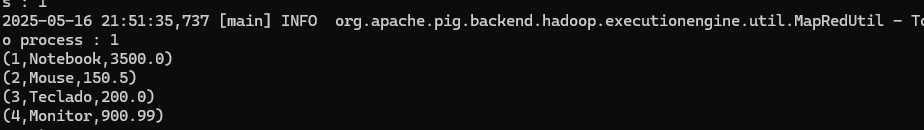


### 2. Em um projeto de implementação de Big Data, você precisa executar consultas básicas em diferentes ferramentas. Para cada tecnologia, escreva uma consulta ou comando para realizar a tarefa especificada:

-   Apache Hive, selecione todos os produtos da tabela "produtos" onde o preço é maior que 100;
-   Hadoop HDFS, liste todos os arquivos no diretório "/input" do HDFS;
-   Apache Pig, filtre as vendas do arquivo "vendas.csv" para mostrar apenas aquelas com valor acima de 500.


a) Apache Hive, selecione todos os produtos da tabela "produtos" onde o preço é maior que 100;


In [101]:
# Consulta os dados
df_2 = spark.sql("SELECT * FROM produtos WHERE preco > 100 ORDER BY id")
df_2.show()

+---+---------+-----+
| id|     nome|preco|
+---+---------+-----+
|  1|Produto A|150.0|
|  3|Produto C|120.0|
+---+---------+-----+



b) Hadoop HDFS, liste todos os arquivos no diretório "/input" do HDFS;


Podemos rodar num servidor Hadoop:

```bash
hdfs dfs -ls /input
```

Ou em nosso notebook:


In [102]:
print(client.list('/input/'))

['config.json', 'dados.csv', 'logs.csv', 'vendas.csv']


c) Apache Pig, filtre as vendas do arquivo "vendas.csv" para mostrar apenas aquelas com valor acima de 500.


```pig
vendas = LOAD 'vendas.csv' USING PigStorage(',') AS (id:int, produto:chararray, valor:double);
vendas_filtradas = FILTER vendas BY valor > 500;
DUMP vendas_filtradas;
```


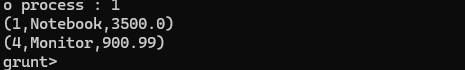


### 3. Em um projeto de Big Data, você precisa carregar dados em diferentes ferramentas. Para cada tecnologia abaixo, escreva um comando ou script para realizar a tarefa de carregamento de dados especificada:

-   Apache Hive, carregue dados de um arquivo CSV chamado "vendas.csv" para uma tabela Hive chamada "vendas" com as colunas: id (INT), produto (STRING), valor (FLOAT);
-   Hadoop HDFS, carregue um arquivo local "clientes.txt" para o diretório "/data" no HDFS;
-   Apache Spark, leia um arquivo JSON chamado "config.json" e crie um DataFrame.


a) Apache Hive, carregue dados de um arquivo CSV chamado "vendas.csv" para uma tabela Hive chamada "vendas" com as colunas: id (INT), produto (STRING), valor (FLOAT);


In [103]:
# Sobe nosso arquivo de vendas.csv no HDFS
client.upload('/input/vendas.csv', './work/data/vendas.csv', overwrite=True)

# Deleta a tabela de vendas se já existir
spark.sql("DROP TABLE IF EXISTS vendas")

# Cria tabela Hive
spark.sql("""
CREATE TABLE IF NOT EXISTS vendas (
    id INT,
    produto STRING,
    valor FLOAT
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
""")

# Salva os dados no HDFS ignorando o cabeçalho
spark.sql("LOAD DATA INPATH '/input/vendas.csv' INTO TABLE vendas;")

# Consulta os dados
df_3 = spark.sql("SELECT * FROM vendas ORDER BY id")

# Consulta os dados
df_3.show()

+---+--------+------+
| id| produto| valor|
+---+--------+------+
|  1|Notebook|3500.0|
|  2|   Mouse| 150.5|
|  3| Teclado| 200.0|
|  4| Monitor|900.99|
+---+--------+------+



b) Hadoop HDFS, carregue um arquivo local "clientes.txt" para o diretório "/data" no HDFS;


Podemos rodar num servidor Hadoop:

```bash
hdfs dfs -put clientes.txt /data
```

Ou em nosso notebook:


In [104]:

client.upload('/data/clientes.txt', './work/data/clientes.txt', overwrite=True)

'/data/clientes.txt'

c) Apache Spark, leia um arquivo JSON chamado "config.json" e crie um DataFrame.


In [105]:
# Sobe nosso arquivo de config.json no HDFS
client.upload('/input/config.json', './work/data/config.json', overwrite=True)

'/input/config.json'

In [106]:
# Le o arquivo no HDFS a cria um dataframe Spark
df_config = spark.read.json("hdfs://namenode:8020/input/config.json", multiLine=True)
df_config.show(truncate=False)

+-------+---------+
|nome   |tipo     |
+-------+---------+
|Infnet |faculdade|
|Estácio|faculdade|
|Unifor |faculdade|
|Unip   |faculdade|
|UFMG   |faculdade|
|PUC    |faculdade|
|UFBA   |faculdade|
+-------+---------+



### 4. Você precisa realizar operações de transformação de dados em diferentes ferramentas. Para cada tecnologia, escreva um comando ou script para realizar a tarefa de transformação especificada:

-   Apache Hive, crie uma nova tabela "vendas_resumo" que contenha o total de vendas por produto a partir da tabela "vendas" (id INT, produto STRING, valor FLOAT);
-   Apache Pig, agrupe os dados do arquivo "logs.csv" (colunas: data, ip, url) por URL e conte o número de acessos para cada URL;
-   Apache Spark, usando um DataFrame "df" criado a partir de "vendas.csv" (colunas: id, produto, valor), calcule o valor total de vendas por produto.


a) Apache Hive, crie uma nova tabela "vendas_resumo" que contenha o total de vendas por produto a partir da tabela "vendas" (id INT, produto STRING, valor FLOAT);


In [107]:
# Cria tabela Hive
spark.sql("""
CREATE TABLE IF NOT EXISTS vendas_resumo
    AS SELECT
        produto,
        SUM(valor) as total_vendas
    FROM vendas
    GROUP BY produto;
""")

# Consulta os dados
df_4 = spark.sql("SELECT * FROM vendas_resumo ORDER BY produto")

# Consulta os dados
df_4.show()

+--------+----------------+
| produto|    total_vendas|
+--------+----------------+
| Monitor|1801.97998046875|
|   Mouse|           301.0|
|Notebook|          7000.0|
| Teclado|           400.0|
+--------+----------------+



b) Apache Pig, agrupe os dados do arquivo "logs.csv" (colunas: data, ip, url) por URL e conte o número de acessos para cada URL;


```pig
logs = LOAD 'logs.csv' USING PigStorage(',') AS (data:chararray, ip:chararray, url:chararray);
grouped = GROUP logs BY url;
url_counts = FOREACH grouped GENERATE group AS url, COUNT(logs) AS acessos;
DUMP url_counts;
```


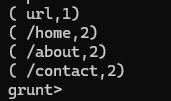


c) Apache Spark, usando um DataFrame "df" criado a partir de "vendas.csv" (colunas: id, produto, valor), calcule o valor total de vendas por produto.


In [108]:
from pyspark.sql.functions import sum

# Sobe nosso arquivo de vendas.csv no HDFS
client.upload('/input/vendas.csv', './work/data/vendas.csv', overwrite=True)

# Le o arquivo no HDFS a cria um dataframe Spark
df = spark.read.csv("hdfs://namenode:8020/input/vendas.csv", header=False, inferSchema=True)
df = df.withColumnRenamed("_c0", "id") \
    .withColumnRenamed("_c1", "produto") \
    .withColumnRenamed("_c2", "valor")
    
# Calcula o total de vendas por produto
df_resumo = df.groupBy("produto").agg(sum("valor").alias("total_vendas")).show(truncate=False)

+--------+------------+
|produto |total_vendas|
+--------+------------+
|Mouse   |150.5       |
|Notebook|3500.0      |
|Monitor |900.99      |
|Teclado |200.0       |
+--------+------------+



### 5. Em um projeto de implementação de Big Data utilizando o ecossistema Hadoop, você precisa demonstrar o entendimento do conceito de ETL/ELT. Para cada tecnologia, descreva uma tarefa simples de ETL ou ELT:

-   Apache Hive, descreva como você usaria o Hive para extrair dados de uma tabela "vendas_brutas", transformar calculando o total de vendas por produto, e carregar em uma nova tabela "vendas_resumo";
-   Hadoop HDFS e MapReduce, explique como você implementaria um processo ETL para contar palavras em arquivos de texto armazenados no HDFS;
-   Apache Pig, explique como você usaria o Pig para realizar um processo ETL que filtra registros de log e calcula estatísticas básicas.


a) Apache Hive, descreva como você usaria o Hive para extrair dados de uma tabela "vendas_brutas", transformar calculando o total de vendas por produto, e carregar em uma nova tabela "vendas_resumo";

Usando o hive poderiamos realizar as transformações criando uma nova tabela vendas_resumo a partir de vendas_brutas:

```sql
CREATE TABLE IF NOT EXISTS vendas_resumo AS
    SELECT
        produto_id,
        SUM(valor_venda) AS total_vendas
    FROM vendas_brutas
    GROUP BY produto_id;
```

b) Hadoop HDFS e MapReduce, explique como você implementaria um processo ETL para contar palavras em arquivos de texto armazenados no HDFS;

Poderiamos criar o seguinte fluxo:

1. Extract:
 Ler arquivos de texto do HDFS (ex: /dados/textos/*.txt).

2. Transform:
 Criar um programa MapReduce com:
 - Mapper: Divide o texto em palavras e emite (palavra, 1);
 - Reducer: Soma todas as ocorrências por palavra.

3. Load:
Salvar os resultados no HDFS, por exemplo, em /resultados/contagem_palavras.txt

c) Apache Pig, explique como você usaria o Pig para realizar um processo ETL que filtra registros de log e calcula estatísticas básicas.

Poderiamos criar um fluxo:

```pig
logs = LOAD '/logs/' USING TextLoader AS (linha:chararray);

erros = FILTER logs BY linha MATCHES '.*ERROR.*';
tipos = FOREACH erros GENERATE FLATTEN(REGEX_EXTRACT(linha, 'ERROR\\s+(\\w+):', 1)) AS tipo_erro;

resumo = GROUP tipos BY tipo_erro;
contagem = FOREACH resumo GENERATE group AS tipo_erro, COUNT(tipos) AS total;

STORE contagem INTO '/output/erros_por_tipo' USING PigStorage(',');
```

### 6. Para importar dados de um banco de dados SQL Server para o ecossistema Hadoop, utilizando Apache Spark, como você escreveria um código PySpark para ler os dados de uma tabela chamada "clientes" diretamente do SQL Server.

Poderiamos utilizar um código assim:

```python
spark = SparkSession.builder \
    .appName("SQLServer - Hadoop") \
    .config("spark.jars", "/path/to/mssql-jdbc-[VERSAO_DO_DRIVER].jre8.jar") \
    .getOrCreate()

jdbc_url = "jdbc:sqlserver://your_server:1433;databaseName=your_database"
connection_properties = {
    "user": "NOME_USUARIO",
    "password": "SENHA",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

df = spark.read.jdbc(url=jdbc_url, table="clientes", properties=connection_properties)
```

### 7. Em um projeto de Big Data utilizando HBase, você precisa realizar operações básicas e integrar o HBase com outras ferramentas do ecossistema Hadoop. Para cada item, escreva um comando ou explique brevemente como realizaria a tarefa: 
- HBase, crie uma tabela chamada "clientes" com uma família de colunas chamada "info"; 
- HBase, insira um novo registro na tabela "clientes" com a chave de linha "1001", nome "Alice" e email "alice@email.com"; 
- Apache Pig, escreva um script Pig para ler dados da tabela "clientes" do HBase.

a) HBase, crie uma tabela chamada "clientes" com uma família de colunas chamada "info"; 

**Primeiros podemos logar em nosso container Hbase**

```bash
docker exec -it hbase bash
hbase shell
```

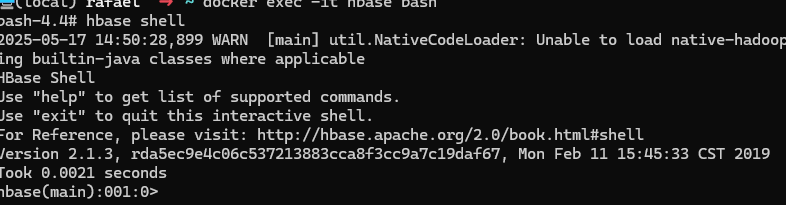

b) HBase, insira um novo registro na tabela "clientes" com a chave de linha "1001", nome "Alice" e email "alice@email.com";

```bash
create 'clientes', 'info'
put 'clientes', '1001', 'info:nome', 'Alice'
put 'clientes', '1001', 'info:email', 'alice@email.com'
```

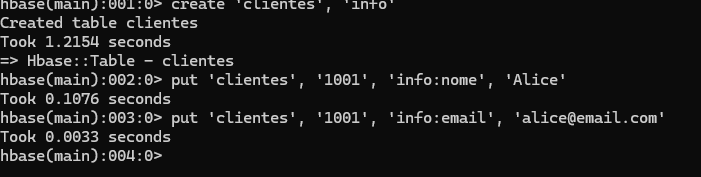

c) Apache Pig, escreva um script Pig para ler dados da tabela "clientes" do HBase.

```pig
REGISTER /usr/lib/pig/piggybank.jar;

DEFINE HBaseStorage org.apache.pig.backend.hadoop.hbase.HBaseStorage();

clientes = LOAD 'hbase://clientes' USING org.apache.pig.backend.hadoop.hbase.HBaseStorage('info:nome info:email', '-loadKey true') AS (id:chararray, nome:chararray, email:chararray);

DUMP clientes;
```

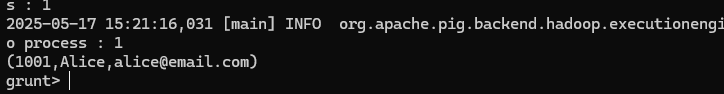

### 8. Utilizando o HBase, você precisa configurar e gerenciar tabelas. Para cada item, escreva um comando ou explique brevemente como realizaria a tarefa: crie uma tabela chamada "vendas" com duas famílias de colunas: "info" e "detalhes", altere a tabela "vendas" para adicionar uma nova família de colunas chamada "estatísticas", liste todas as tabelas existentes no HBase e mostre a estrutura detalhada da tabela "vendas".

```bash
create 'vendas', 'info', 'detalhes'
alter 'vendas', 'estatisticas'
list
describe 'vendas'
```

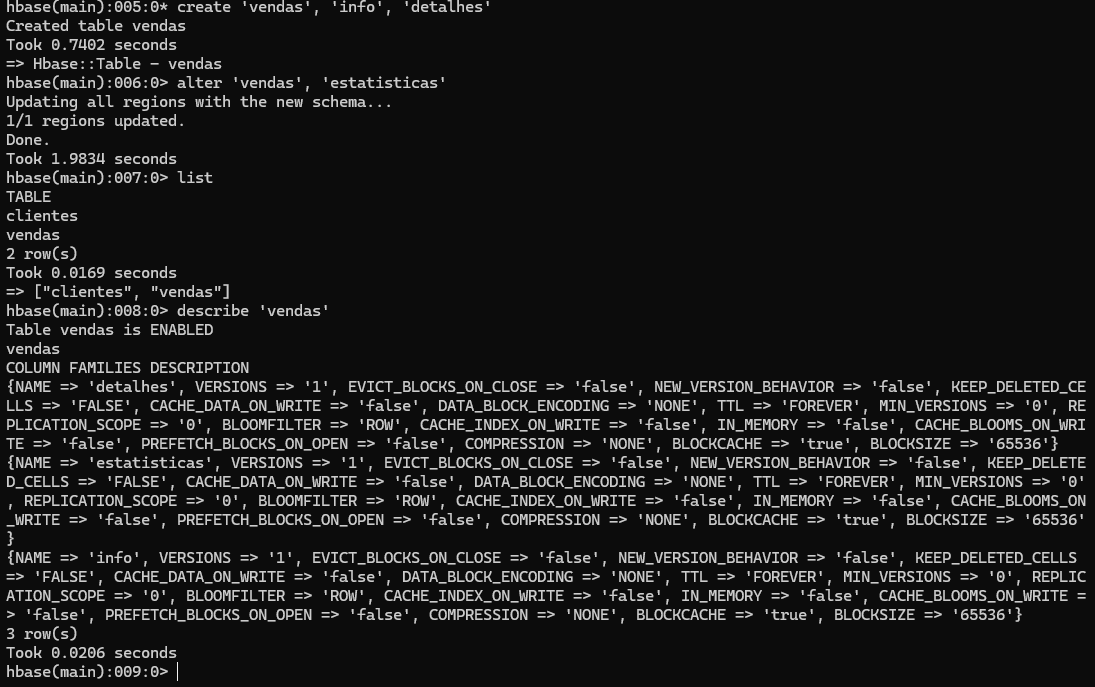